In [22]:
import os, sys, json
from pprint import pprint

import numpy as np

from vis_samples import highlight_steps
from const import dataset_model_best_lr, LETTERS
from stats import changed_prediction, average_efficacy, instance_specificity, compute_specificity, make_stats, instance_changed_prediction
from util import load_results, unique_instances, filter_for_agreement, group_results, renorm, sort_key

## Define datasets & models from which we take annotation instances

In [23]:
datasets = ['arc-challenge', 'sqa']
models = ['LLaMA-3', 'LLaMA-3-3B']

In [24]:
def heatmap_stats(path_root, type="sentencize", method='npo_KL', rs=1001,
                   ff2=True, pos=True):
    results = {}
    for dataset in datasets:
        for model in models:
            lr = dataset_model_best_lr[dataset][model]
           
            floc = f'{path_root}/{dataset}/{model}/{method}_{type}_s=True_lr={lr}_rs={rs}_pos={pos}_ff2={ff2}.out'
            if not os.path.exists(floc):
                continue
    
            per_instance_results = load_results(floc)
            
            if per_instance_results:
                key = f"{dataset},{model},{method},{lr}"
                results[key] = make_stats(per_instance_results)
    return results

In [25]:
def heatmap_instances(path_root, type="sentencize", method='npo_KL', rs=1001,
                   ff2=True, pos=True):
    results = {}
    for dataset in datasets:
        for model in models:
            lr = dataset_model_best_lr[dataset][model]

            floc = f'{path_root}/{dataset}/{model}/{method}_{type}_s=True_lr={lr}_rs={rs}_pos={pos}_ff2={ff2}.out'
            if not os.path.exists(floc):
                continue
    
            per_instance_results = load_results(floc)
            
            if per_instance_results:
                key = f"{dataset},{model},{method},{lr}"
                results[key] = per_instance_results
    return results

In [26]:
def max_mass_shift(a_result, do_print=False):
    # Negative -> probability gets added, positive -> probability gets removed
    unlearning_results = a_result['unlearning_results']
    probs = [renorm(r['probs']) for  _, r in unlearning_results.items()]

    initial_pred = np.argmax(probs[0])
    initial_mass = probs[0][initial_pred]
    dmass = [initial_mass - m[initial_pred] for m in probs[1:]]

    if do_print:
        print(probs, '\n', initial_mass, dmass)
    return max(dmass)

In [27]:
def max_abs_mass_shift(a_result, do_print=False):
    # Negative -> probability gets added, positive -> probability gets removed
    unlearning_results = a_result['unlearning_results']
    probs = [renorm(r['probs']) for  _, r in unlearning_results.items()]

    initial_pred = np.argmax(probs[0])
    initial_mass = probs[0][initial_pred]
    abs_dmass = [np.abs(initial_mass - m[initial_pred]) for m in probs[1:]]
    dmass_idx = np.argmax(abs_dmass)
    dmass = [initial_mass - m[initial_pred] for m in probs[1:]]
    
    
    if do_print:
        print(probs, '\n', initial_mass, dmass)
    return dmass[dmass_idx]

In [28]:
def compute_salient_steps(some_results):
    steps_causing_flip = {}
    steps_most_mass = {}
    
    for idx, (a_key, results) in enumerate(some_results.items()):
        d, m, _, _ = a_key.split(",")
        k_s = ' '.join([d,m])
        
        boolean = []
        
        for i, (q_key, q_results) in enumerate(results.items()):
            salience_scores = [0] * len(q_results[0]['segmented_cot'])
            for unlearned_step in q_results:
                step_idx = unlearned_step['step_idx']
                mass = max_mass_shift(unlearned_step, do_print=False)
                print(q_results[0]['segmented_cot'][step_idx], mass)
                salience_scores[step_idx] = mass
                step_results = unlearned_step['unlearning_results']
                has_flip, flips = instance_changed_prediction(step_results)
                boolean.append(has_flip)

            if not any(boolean) or max(salience_scores) < 0.1: continue
            question = q_results[0]['question']
            options = q_results[0]['options']
            steps = q_results[0]['segmented_cot']
            correct = LETTERS.index(q_results[0]['correct'])
            predicted = q_results[0]['prediction']

            highlight_steps(question, options, steps, correct, predicted, salience_scores)

        if idx > 3: break
    
    return step_faithfulness_stats

In [29]:
final_results = heatmap_instances("results", "sentencize", ff2=True, pos=True)

In [30]:
filtered_results = {}
for a_key, result in sorted(final_results.items(), key=lambda t: sort_key(t[0])):
    dataset, model, _, _ = a_key.split(",")
    filtered_result = filter_for_agreement(result)
    filtered_results[a_key] = filtered_result

## Generate data for annotation

In [31]:
grouped_results = group_results(filtered_results)

In [32]:
import matplotlib.pyplot as plt

PLOT_BINS = [-0.5, -0.4, -0.3, -0.2, -0.1, 0., .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]

def plot_prob_change_scatter(grouped_results):
    fig, axs = plt.subplots(2,2, figsize=(10,4))
    
    for idx, (key, results) in enumerate(grouped_results.items()):
        row, col = idx//2, idx%2
        d, m, _, _ = key.split(",")
        # candidate_results[key] = {} # q_key_step_idx

        scatter_flip = [] # Just a histogram of this
        scatter_noflip = []
        
        for i, (q_key, q_results) in enumerate(results.items()):
            salience_scores = [0] * len(q_results[0]['segmented_cot'])
            for unlearned_step in q_results:
                # print(unlearned_step['step_idx'])
                mass = max_abs_mass_shift(unlearned_step, do_print=False)
                step_results = unlearned_step['unlearning_results']
                has_flip, flips = instance_changed_prediction(step_results)
                if has_flip:
                    scatter_flip.append(mass)
                else:
                    scatter_noflip.append(mass)

        flip_counts, flip_bins = np.histogram(scatter_flip, bins=PLOT_BINS)
        noflip_counts, noflip_bins = np.histogram(scatter_noflip, bins=PLOT_BINS)
                
        axs[row][col].axvspan(-.5, -.25, alpha=0.2, color='lightcoral')
        axs[row][col].axvspan(.25, .49, alpha=0.2, color='palegreen')
        axs[row][col].axvspan(.5, 1., alpha=0.2, color='darkgreen')

        axs[row][col].stairs(flip_counts, flip_bins)
        axs[row][col].stairs(noflip_counts, noflip_bins)

        
        axs[row][col].set_xlabel('Probability shifted from initial answer')
        axs[row][col].set_ylabel('Frequency')
        m_name = m if m == 'LLaMA-3-3B' else 'LLaMA-3-8B'
        d_name = 'ARC-challenge' if d != 'sqa' else 'StrategyQA'
        axs[row][col].set_title(f"{d_name} => {m_name}")
    fig.tight_layout()
    plt.savefig("figures/flip_histograms.pdf")
    plt.show()

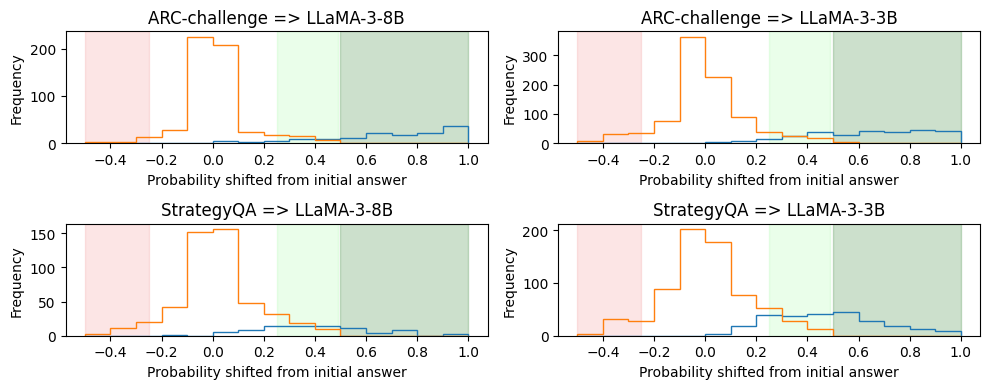

In [33]:
# Sample from everything except the [-.2, .2 interval]
plot_prob_change_scatter(grouped_results)

In [34]:
import csv

def generate_annotation_data(grouped_results):
    candidate_results = {}
    for idx, (key, results) in enumerate(grouped_results.items()):
        d, m, _, _ = key.split(",")
        if m == 'LLaMA-3':
            m = 'LLaMA-3-8B'

        duplicate_candidates = set()
        candidate_results[key] = {
            'neg_bin': [],
            'med_bin': [],
            'high_bin': [],
        } # q_key_step_idx

        with open(f'annotation_data/{d}_{m}_neg_bin.csv', 'w') as neg_out,\
            open(f'annotation_data/{d}_{m}_med_bin.csv', 'w') as med_out,\
            open(f'annotation_data/{d}_{m}_high_bin.csv', 'w') as high_out:
            neg_writer = csv.writer(neg_out, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            med_writer = csv.writer(med_out, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            high_writer = csv.writer(high_out, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            HEADER = ['ID','Question','options','segmented_cot','correct_answer','predicted_answer','target_step_idx', 'dp', 'flip','dataset','model']
            neg_writer.writerow(HEADER)
            med_writer.writerow(HEADER)
            high_writer.writerow(HEADER)
            
            
            for i, (q_key, q_results) in enumerate(results.items()):
                salience_scores = [0] * len(q_results[0]['segmented_cot'])
                for unlearned_step in q_results:
                    step_idx = unlearned_step['step_idx']
        
                    mass = max_abs_mass_shift(unlearned_step, do_print=False)
                    step_results = unlearned_step['unlearning_results']
                    has_flip, flips = instance_changed_prediction(step_results)
    
                    
                    inst_id = q_results[0]['id']

                    duplicate_id = f"{inst_id}_{step_idx}"
                    if duplicate_id in duplicate_candidates:
                        continue
                    else:
                        duplicate_candidates.add(duplicate_id)

                    question = q_results[0]['question']
                    options = "||".join(q_results[0]['options'])
                    steps = "||".join(q_results[0]['segmented_cot'])
                    correct = LETTERS.index(q_results[0]['correct'])
                    predicted = q_results[0]['prediction']
                    dp = f"{mass:.3f}"
                    flip = str(has_flip)
                    target_step = step_idx # target_id
                    
                    inst_data = [inst_id,question,options,steps,correct,predicted,target_step,dp,flip,d,m]
                    
                    if mass <= -.25:
                        candidate_results[key]['neg_bin'].append(inst_data)
                        neg_writer.writerow(inst_data)
                    elif mass >= .25 and mass < .50:
                        candidate_results[key]['med_bin'].append(inst_data)
                        med_writer.writerow(inst_data)
                    elif mass >= .50:
                        candidate_results[key]['high_bin'].append(inst_data)
                        high_writer.writerow(inst_data)
    return candidate_results

In [35]:
candidate_results = generate_annotation_data(grouped_results)

In [39]:
import random
annotation_instances = []

for k, bins in candidate_results.items():
    d, m, _, _ = k.split(",")
    if m == 'LLaMA-3':
        m = 'LLaMA-3-8B'
    carry = 0
    for bin_name, N in zip(['high_bin', 'med_bin', 'neg_bin'], [15, 5, 5]):
        bin_samples = bins[bin_name]

        N_carry = N+carry
        N_b = len(bin_samples)

        if N_carry > N_b:
            bin_selected = bin_samples
            carry = N_carry - N_b
        else:
            bin_selected = random.sample(bin_samples, N_carry)
            carry = 0

        annotation_instances.extend(bin_selected)
        print(f"Taking {len(bin_selected)} samples from {bin_name}, carry = {carry}")

random.shuffle(annotation_instances)

HEADER = ['ID','Question','options','segmented_cot','correct_answer','predicted_answer','target_step_idx', 'dp', 'flip','dataset','model']
with open(f'annotation_data/annotation_sample_5_5_15_shuffled.csv', 'w') as out:
    writer = csv.writer(out, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(HEADER)
    for instance in annotation_instances:
        writer.writerow(instance)

arc-challenge,LLaMA-3,npo_KL,1e-05
Taking 15 samples from high_bin, carry = 0
Taking 5 samples from med_bin, carry = 0
Taking 5 samples from neg_bin, carry = 0
arc-challenge,LLaMA-3-3B,npo_KL,3e-05
Taking 15 samples from high_bin, carry = 0
Taking 5 samples from med_bin, carry = 0
Taking 5 samples from neg_bin, carry = 0
sqa,LLaMA-3,npo_KL,1e-05
Taking 15 samples from high_bin, carry = 0
Taking 5 samples from med_bin, carry = 0
Taking 5 samples from neg_bin, carry = 0
sqa,LLaMA-3-3B,npo_KL,3e-05
Taking 15 samples from high_bin, carry = 0
Taking 5 samples from med_bin, carry = 0
Taking 5 samples from neg_bin, carry = 0
